In [55]:
pip install scikit-image


In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === 1. Define Feature Attention Module ===
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        w = self.fc(self.avg_pool(x))
        return x * w

# === 2. Define EAM Block (dilated convs + residuals + attention) ===
class EAMBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.branch1 = nn.Conv2d(channels, channels, kernel_size=3, padding=2, dilation=2)
        self.branch2 = nn.Conv2d(channels, channels, kernel_size=3, padding=3, dilation=3)
        self.merge = nn.Conv2d(2 * channels, channels, kernel_size=1)

        self.res_block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )

        self.compress = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=1)
        )

        self.attention = ChannelAttention(channels)

    def forward(self, x):
        b1 = self.branch1(x)
        b2 = self.branch2(x)
        merged = torch.cat([b1, b2], dim=1)
        merged = self.merge(merged)

        res = self.res_block(merged)
        comp = self.compress(res)
        attended = self.attention(comp)

        return x + attended  # short skip connection

# === 3. Full Mini RIDNet with Residual on Residual ===
class MiniRIDNet(nn.Module):
    def __init__(self, in_channels=1, num_blocks=4):
        super().__init__()
        self.entry = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)

        self.eam_blocks = nn.Sequential(
            *[EAMBlock(64) for _ in range(num_blocks)]
        )

        self.exit = nn.Conv2d(64, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x_initial = self.entry(x)
        x_mid = self.eam_blocks(x_initial)
        x_final = self.exit(x_mid)
        return x + x_final  # residual learning of noise

# === 4. Noise Function ===
def add_noise(imgs, noise_level=0.5):
    noise = torch.randn_like(imgs) * noise_level
    return torch.clamp(imgs + noise, 0., 1.)

# === 5. Dataset ===
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

# === 6. Training ===
model = MiniRIDNet().to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("Training...")
for epoch in range(5):
    model.train()
    total_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        noisy_images = add_noise(images, noise_level=0.5)

        optimizer.zero_grad()
        outputs = model(noisy_images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")



Training...
Epoch 1, Loss: 0.0449
Epoch 2, Loss: 0.0329
Epoch 3, Loss: 0.0311
Epoch 4, Loss: 0.0302
Epoch 5, Loss: 0.0298


In [58]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

print("\nEvaluating on test set...")

model.eval()
total_psnr = 0
total_ssim = 0
num_samples = 0

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        noisy_images = add_noise(images, noise_level=0.1)
        outputs = model(noisy_images)

        # Move to CPU and denormalize
        outputs = denormalize(outputs.cpu()).numpy()  # [B, C, H, W]
        targets = denormalize(images.cpu()).numpy()

        for i in range(outputs.shape[0]):
            output_img = np.transpose(outputs[i], (1, 2, 0))  # [H, W, C]
            target_img = np.transpose(targets[i], (1, 2, 0))

            psnr_val = psnr(target_img, output_img, data_range=1.0)
            ssim_val = ssim(target_img, output_img, data_range=1.0, channel_axis=2)

            total_psnr += psnr_val
            total_ssim += ssim_val
            num_samples += 1

avg_psnr = total_psnr / num_samples
avg_ssim = total_ssim / num_samples

print(f"\nAverage PSNR: {avg_psnr:.2f} dB")
print(f"Average SSIM: {avg_ssim:.4f}")



Evaluating on test set...

Average PSNR: 31.42 dB
Average SSIM: 0.9723


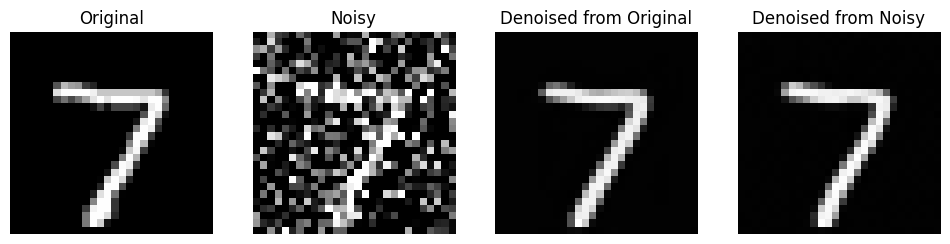

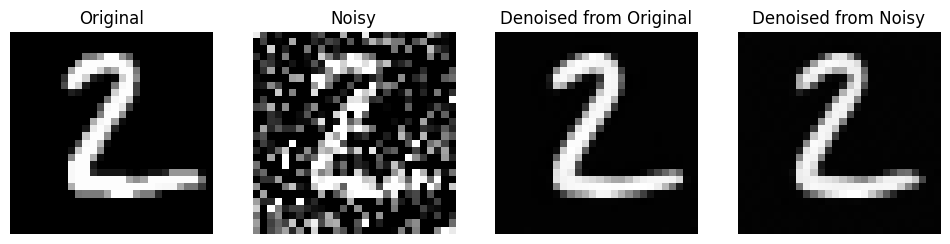

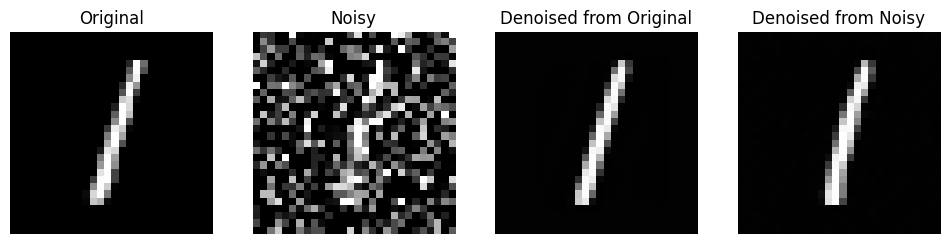

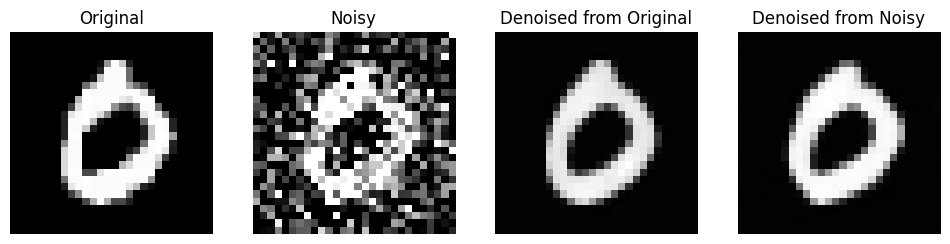

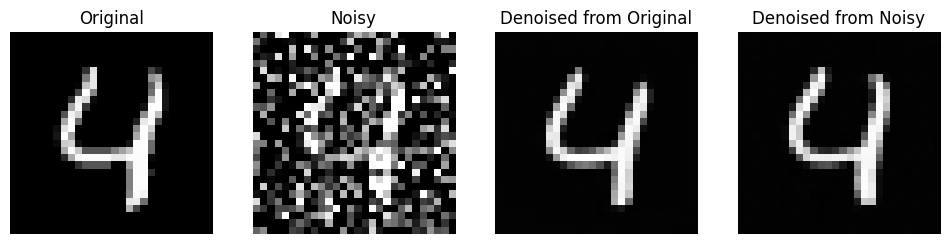

In [46]:
# === 7. Evaluation ===
model.eval()
with torch.no_grad():
    test_images, _ = next(iter(test_loader))
    test_images = test_images.to(device)
    noisy_test_images = add_noise(test_images, noise_level=0.5).to(device)

    denoised_from_clean = model(test_images).cpu()
    denoised_from_noisy = model(noisy_test_images).cpu()
    test_images = test_images.cpu()
    noisy_test_images = noisy_test_images.cpu()

# === 8. Visualization ===
for i in range(5):
    plt.figure(figsize=(12, 3))

    plt.subplot(1, 4, 1)
    plt.imshow(test_images[i][0], cmap='gray')
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(noisy_test_images[i][0], cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(denoised_from_clean[i][0], cmap='gray')
    plt.title("Denoised from Original")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(denoised_from_noisy[i][0], cmap='gray')
    plt.title("Denoised from Noisy")
    plt.axis('off')

    plt.show()


Saving download-(39).png to download-(39) (3).png


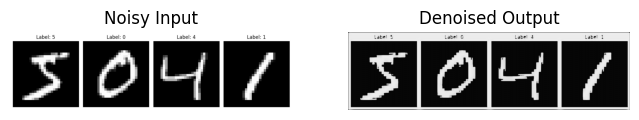

In [40]:
from google.colab import files
uploaded = files.upload()  # Upload your noisy image file


from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Load the uploaded noisy image
img = Image.open(list(uploaded.keys())[0]).convert('L')  # Make sure it's grayscale
#img = img.resize((28, 28))  # Resize to MNIST size if needed

# Convert to tensor
transform = transforms.ToTensor()  # Just [0, 255] -> [0, 1]
noisy_tensor = transform(img).unsqueeze(0).to(device)  # [1, 1, 28, 28]

# Denoise
model.eval()
with torch.no_grad():
    denoised_tensor = model(noisy_tensor)

# Show results
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Noisy Input")
plt.imshow(noisy_tensor.squeeze().cpu(), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Denoised Output")
plt.imshow(denoised_tensor.squeeze().cpu(), cmap='gray')
plt.axis('off')
plt.show()

Saving 1_tfZ8IMnXQrK5Blb_To8gwg.png to 1_tfZ8IMnXQrK5Blb_To8gwg (3).png


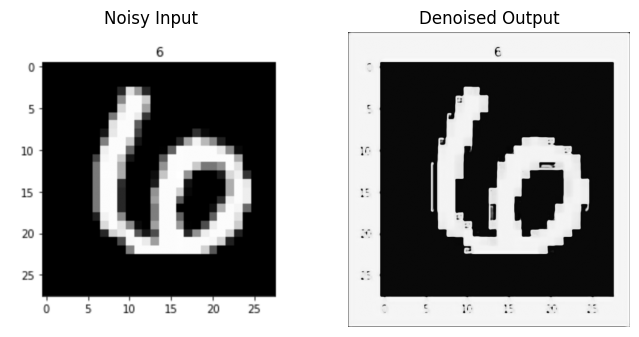

In [41]:
from google.colab import files
uploaded = files.upload()  # Upload your noisy image file


from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Load the uploaded noisy image
img = Image.open(list(uploaded.keys())[0]).convert('L')  # Make sure it's grayscale
#img = img.resize((28, 28))  # Resize to MNIST size if needed

# Convert to tensor
transform = transforms.ToTensor()  # Just [0, 255] -> [0, 1]
noisy_tensor = transform(img).unsqueeze(0).to(device)  # [1, 1, 28, 28]

# Denoise
model.eval()
with torch.no_grad():
    denoised_tensor = model(noisy_tensor)

# Show results
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Noisy Input")
plt.imshow(noisy_tensor.squeeze().cpu(), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Denoised Output")
plt.imshow(denoised_tensor.squeeze().cpu(), cmap='gray')
plt.axis('off')
plt.show()

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === 1. Define Feature Attention Module ===
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        w = self.fc(self.avg_pool(x))
        return x * w

# === 2. Define EAM Block (dilated convs + residuals + attention) ===
class EAMBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.branch1 = nn.Conv2d(channels, channels, kernel_size=3, padding=2, dilation=2)
        self.branch2 = nn.Conv2d(channels, channels, kernel_size=3, padding=3, dilation=3)
        self.merge = nn.Conv2d(2 * channels, channels, kernel_size=1)

        self.res_block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )

        self.compress = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=1)
        )

        self.attention = ChannelAttention(channels)

    def forward(self, x):
        b1 = self.branch1(x)
        b2 = self.branch2(x)
        merged = torch.cat([b1, b2], dim=1)
        merged = self.merge(merged)

        res = self.res_block(merged)
        comp = self.compress(res)
        attended = self.attention(comp)

        return x + attended  # short skip connection

# === 3. Full Mini RIDNet with Residual on Residual ===
class MiniRIDNet(nn.Module):
    def __init__(self, in_channels=3, num_blocks=4):
        super().__init__()
        self.entry = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)

        self.eam_blocks = nn.Sequential(
            *[EAMBlock(64) for _ in range(num_blocks)]
        )

        self.exit = nn.Conv2d(64, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x_initial = self.entry(x)
        x_mid = self.eam_blocks(x_initial)
        x_final = self.exit(x_mid)
        return torch.clamp(x + x_final, -1., 1.)  # residual learning and clamping output

# === 4. Noise Function ===
def add_noise(imgs, noise_level=0.1):
    noise = torch.randn_like(imgs) * noise_level
    return torch.clamp(imgs + noise, -1., 1.)

# === 5. Dataset ===
from torchvision.datasets import CIFAR10

def denormalize(t):
    return t * 0.5 + 0.5

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

train_dataset = CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = CIFAR10(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

# === 6. Training ===
model = MiniRIDNet(in_channels=3).to(device)
criterion = nn.L1Loss()  # changed from MSE to L1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("Training...")
for epoch in range(5):
    model.train()
    total_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        noisy_images = add_noise(images, noise_level=0.1)

        optimizer.zero_grad()
        outputs = model(noisy_images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")



Training...
Epoch 1, Loss: 0.0401
Epoch 2, Loss: 0.0356
Epoch 3, Loss: 0.0351
Epoch 4, Loss: 0.0348
Epoch 5, Loss: 0.0347


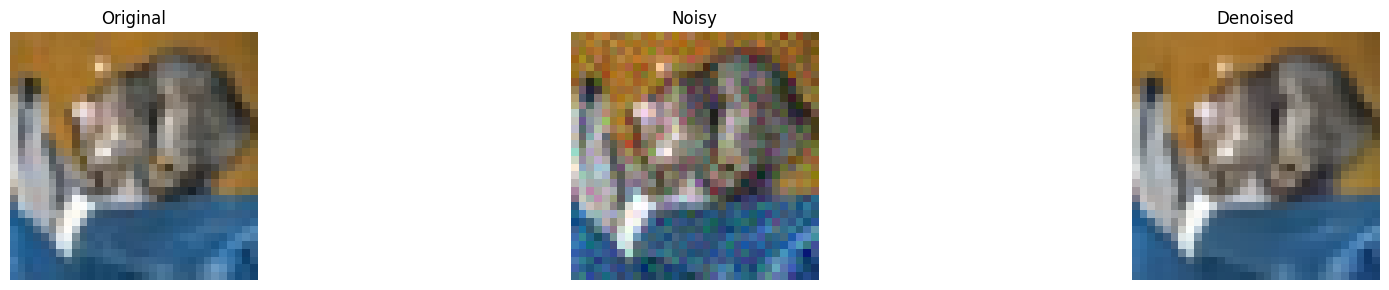

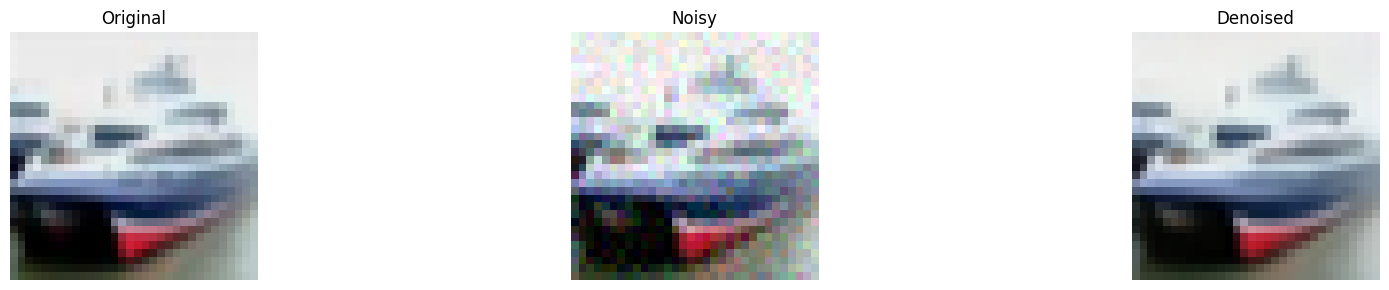

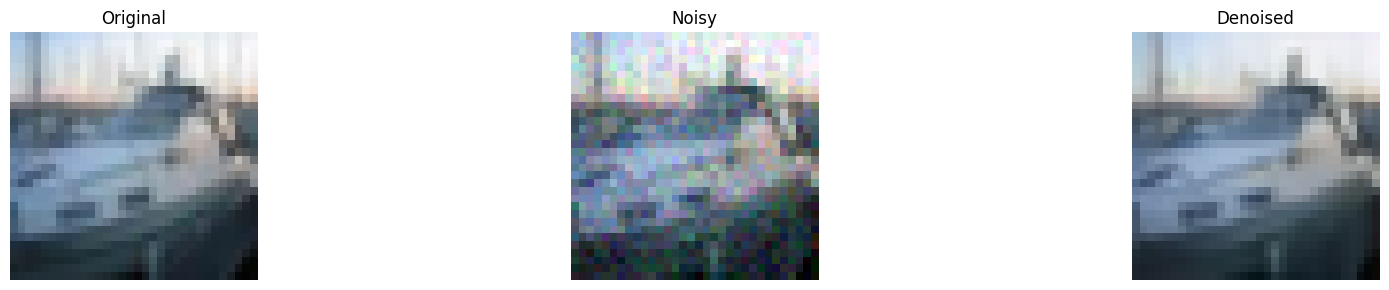

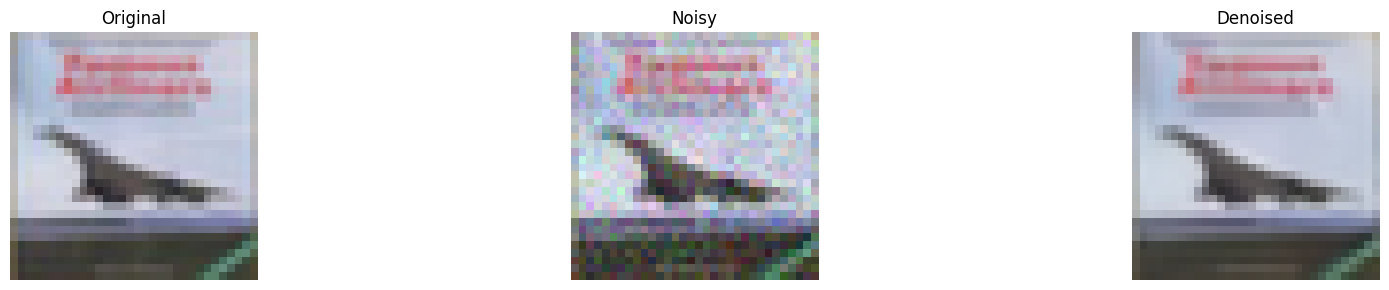

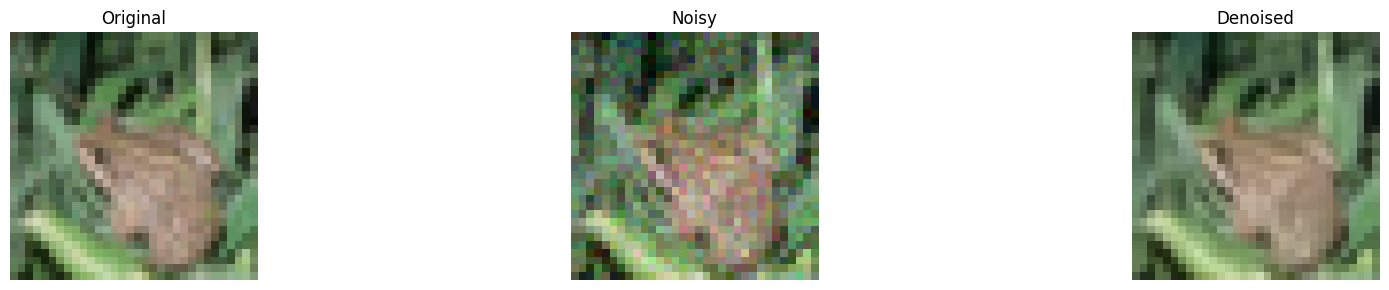

In [49]:
import torch.nn.functional as F

# Optional: Upscale factor (to make CIFAR-10 more viewable)
UPSCALE_FACTOR = 4

# === 7. Evaluation ===
model.eval()
with torch.no_grad():
    test_images, _ = next(iter(test_loader))
    noisy_test_images = add_noise(test_images, noise_level=0.1).to(device)
    denoised_images = model(noisy_test_images).cpu()

# === 8. Visualization ===
plt.rcParams['image.interpolation'] = 'none'  # disable automatic interpolation

for i in range(5):
    plt.figure(figsize=(19, 3), dpi=100)

    # Denormalize and Upscale
    orig = F.interpolate(denormalize(test_images[i].unsqueeze(0)), scale_factor=UPSCALE_FACTOR, mode='nearest').squeeze(0)
    noisy = F.interpolate(denormalize(noisy_test_images[i].cpu().unsqueeze(0)), scale_factor=UPSCALE_FACTOR, mode='nearest').squeeze(0)
    denoised = F.interpolate(denormalize(denoised_images[i].unsqueeze(0)), scale_factor=UPSCALE_FACTOR, mode='nearest').squeeze(0)

    # Convert to numpy and plot
    plt.subplot(1, 3, 1)
    plt.imshow(np.transpose(orig.numpy(), (1, 2, 0)))
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(np.transpose(noisy.numpy(), (1, 2, 0)))
    plt.title("Noisy")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(np.transpose(denoised.numpy(), (1, 2, 0)))
    plt.title("Denoised")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


Saving flower_0.10_noisy.jpg to flower_0.10_noisy (4).jpg


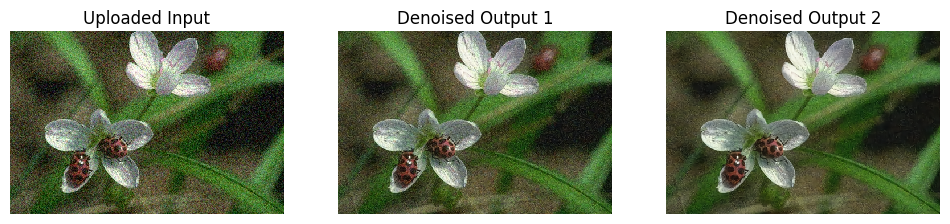

In [52]:
from google.colab import files
uploaded = files.upload()  # Upload your noisy image

from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np

# === Load and Prepare Image ===
img = Image.open(list(uploaded.keys())[0]).convert('RGB')
#img = img.resize((32, 32))  # Resize to CIFAR-10 shape

# Same normalization as training
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize to [-1, 1]
])
input_tensor = transform(img).unsqueeze(0).to(device)  # [1, 3, 32, 32]

# === Denoise ===
model.eval()
with torch.no_grad():
    output_tensor = model(input_tensor)

# === Denoise ===
model.eval()
with torch.no_grad():
    output_tensor2 = model(output_tensor)

# === Denormalize for display ===
def denormalize(t): return t * 0.5 + 0.5

# === Show Results ===
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Uploaded Input")
plt.imshow(np.transpose(denormalize(input_tensor[0].cpu()).numpy(), (1, 2, 0)))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Denoised Output 1")
plt.imshow(np.transpose(denormalize(output_tensor[0].cpu()).numpy(), (1, 2, 0)))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Denoised Output 2")
plt.imshow(np.transpose(denormalize(output_tensor2[0].cpu()).numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()


In [56]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

print("\nEvaluating on test set...")

model.eval()
total_psnr = 0
total_ssim = 0
num_samples = 0

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        noisy_images = add_noise(images, noise_level=0.1)
        outputs = model(noisy_images)

        # Move to CPU and denormalize
        outputs = denormalize(outputs.cpu()).numpy()  # [B, C, H, W]
        targets = denormalize(images.cpu()).numpy()

        for i in range(outputs.shape[0]):
            output_img = np.transpose(outputs[i], (1, 2, 0))  # [H, W, C]
            target_img = np.transpose(targets[i], (1, 2, 0))

            psnr_val = psnr(target_img, output_img, data_range=1.0)
            ssim_val = ssim(target_img, output_img, data_range=1.0, channel_axis=2)

            total_psnr += psnr_val
            total_ssim += ssim_val
            num_samples += 1

avg_psnr = total_psnr / num_samples
avg_ssim = total_ssim / num_samples

print(f"\nAverage PSNR: {avg_psnr:.2f} dB")
print(f"Average SSIM: {avg_ssim:.4f}")



Evaluating on test set...

Average PSNR: 33.01 dB
Average SSIM: 0.9676


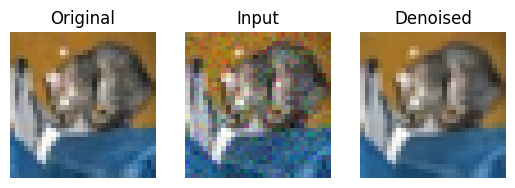

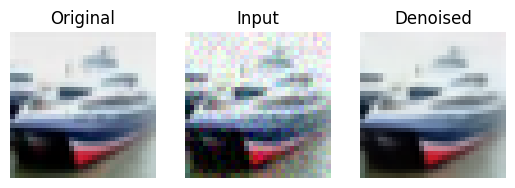

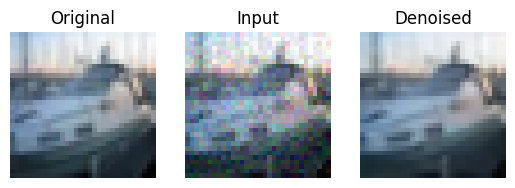

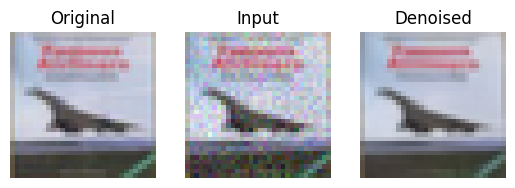

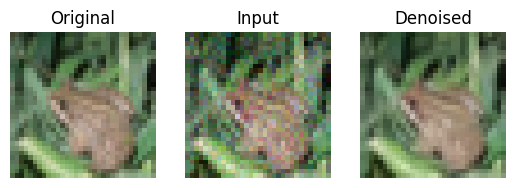

In [53]:

# === 7. Evaluation ===
model.eval()
with torch.no_grad():
    test_images, _ = next(iter(test_loader))
    noisy_test_images = add_noise(test_images).to(device)  # No noise added
    denoised_images = model(noisy_test_images).cpu()

# === 8. Visualization ===
for i in range(5):
    #plt.figure(figsize=(9, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(np.transpose(denormalize(test_images[i]).numpy(), (1, 2, 0)))
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(np.transpose(denormalize(noisy_test_images[i].cpu()).numpy(), (1, 2, 0)))
    plt.title("Input")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(np.transpose(denormalize(denoised_images[i]).numpy(), (1, 2, 0)))
    plt.title("Denoised")
    plt.axis('off')
    plt.show()

Saving Audrey_Hepburn.jpg to Audrey_Hepburn.jpg


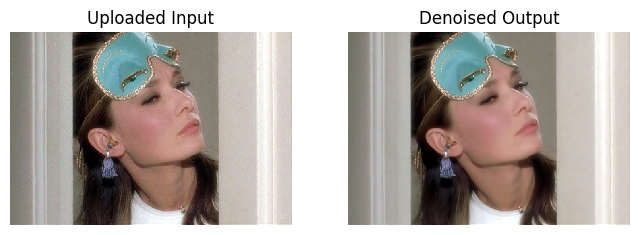

In [54]:
from google.colab import files
uploaded = files.upload()  # Upload your noisy image

from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np

# === Load and Prepare Image ===
img = Image.open(list(uploaded.keys())[0]).convert('RGB')
#img = img.resize((32, 32))  # Resize to CIFAR-10 shape

# Same normalization as training
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize to [-1, 1]
])
input_tensor = transform(img).unsqueeze(0).to(device)  # [1, 3, 32, 32]

# === Denoise ===
model.eval()
with torch.no_grad():
    output_tensor = model(input_tensor)

# === Denormalize for display ===
def denormalize(t): return t * 0.5 + 0.5

# === Show Results ===
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Uploaded Input")
plt.imshow(np.transpose(denormalize(input_tensor[0].cpu()).numpy(), (1, 2, 0)))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Denoised Output")
plt.imshow(np.transpose(denormalize(output_tensor[0].cpu()).numpy(), (1, 2, 0)))
plt.axis('off')

plt.show()